In [17]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import random
%matplotlib inline 

In [4]:
words =  open("names.txt").read().splitlines()

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [23]:
block_size = 3

def build_dataset(word):
    X, Y = [], []

    for w in word:
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182527, 3]) torch.Size([182527])
torch.Size([22742, 3]) torch.Size([22742])
torch.Size([22877, 3]) torch.Size([22877])


In [35]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) * (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else []

class Tanh():

    def __call__(self, x):
        return torch.tanh(x)
    
    def parameters(self):
        return []
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_std  = (1 - self.momentum) * self.running_std + self.momentum * xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]


In [30]:
x = torch.randn(100)

In [31]:
first = Linear(100, 60)
x = first(x)

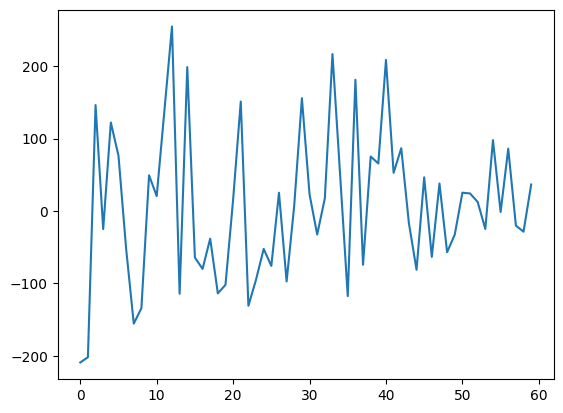

In [33]:
plt.plot(torch.arange(60), x)

In [34]:
torch.tanh(x)

tensor([-1.0000, -1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,
         1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,
        -1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -0.8921,
         1.0000, -1.0000, -1.0000,  1.0000])